In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Set paths based on your folder structure
train_path = '/content/drive/MyDrive/Dataset/train'
val_path = '/content/drive/MyDrive/Dataset/val'
test_path = '/content/drive/MyDrive/Dataset/test'



In [ ]:
import librosa
import numpy as np

def extract_features_with_spectrogram(file_path, max_len=130, feature_dim=156):
    y, sr = librosa.load(file_path, sr=16000)

    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Combine features
    combined = np.vstack([mfcc, chroma, zcr, rolloff, rms, mel_spec_db])

    # Ensure feature dimensions are padded or truncated to fit
    if combined.shape[1] < max_len:
        pad_width = max_len - combined.shape[1]
        combined = np.pad(combined, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        combined = combined[:, :max_len]

    # Ensure the final shape matches (130, 156)
    return combined.T  # shape: (max_len, 156)

# Example usage



In [ ]:
def load_dataset(base_path, max_len=130):
    X, y = [], []

    for label, subfolder in enumerate(["Real", "Synthetic"]):
        folder = os.path.join(base_path, subfolder)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                f = os.path.join(folder, file)
                features = extract_features_with_spectrogram(f, max_len)
                X.append(features)
                y.append(label)

    return np.array(X), np.array(y)


In [ ]:
# Load your datasets
import os
X_train, y_train = load_dataset(train_path)
X_val, y_val = load_dataset(val_path)
X_test, y_test = load_dataset(test_path)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(444, 130, 156) (444,)
(109, 130, 156) (109,)
(160, 130, 156) (160,)


In [ ]:
# Convert features and labels to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)


**Model training**

In [ ]:
# ✅ Import all necessary modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM, Dense
#import tensorflow_addons as tfa


In [ ]:
# ✅ Define input shape based on your extracted feature arrays
input_shape = (130, 156)  # Shape: (Time Steps, Features)

# ✅ Build the model
model = Sequential()

# First CNN Layer
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second CNN Layer
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM Layer for temporal dependencies
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer (Binary Classification)
model.add(Dense(1, activation='sigmoid'))

# Show model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 130, 64)        │        30,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 65, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,121 (426.25 KB)

 Trainable params: 108,737 (424.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)


In [ ]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Stop if no improvement in 3 epochs
    restore_best_weights=True
)

# Fit the model to your training data
history = model.fit(
    X_train, y_train,
    epochs=50,               # Max 50 epochs
    batch_size=16,           # Small batch size for better learning
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.1895 - loss: 0.8833 - val_accuracy: 0.7248 - val_loss: 0.6641
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4574 - loss: 0.7154 - val_accuracy: 0.9174 - val_loss: 0.4786
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7353 - loss: 0.5959 - val_accuracy: 0.9174 - val_loss: 0.3714
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8246 - loss: 0.5305 - val_accuracy: 0.9174 - val_loss: 0.3062
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8750 - loss: 0.4475 - val_accuracy: 0.9358 - val_loss: 0.2659
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9119 - loss: 0.3877 - val_accuracy: 0.9450 - val_loss: 0.2386
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8901 - loss: 0.3386 - val_accuracy: 0.9541 - val_loss: 0.2258
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9011 - loss: 0.2863 - val_accuracy: 0.9541 - v

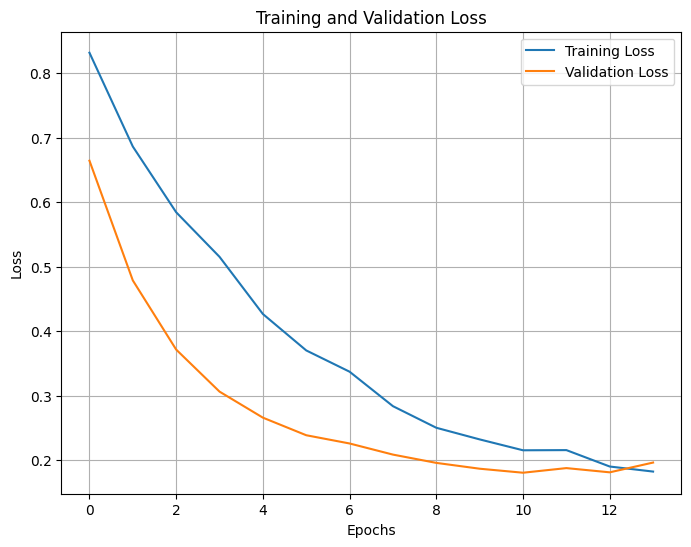

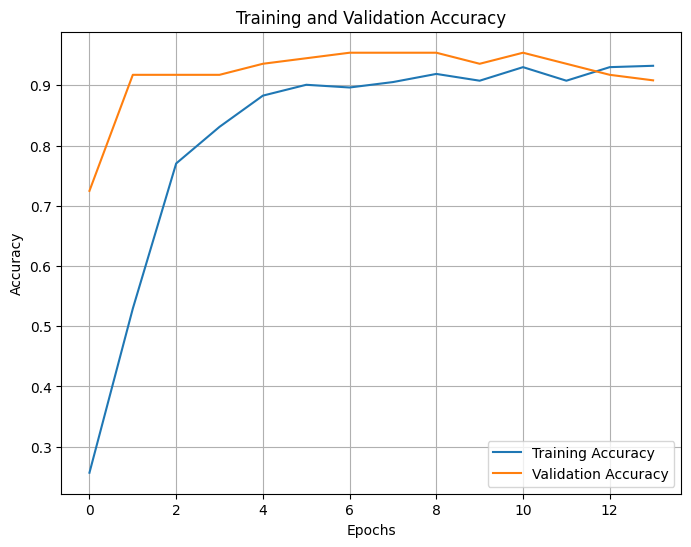

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


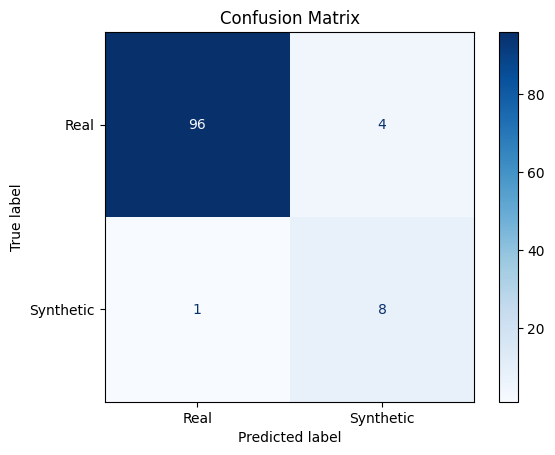

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels on validation set
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Synthetic"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


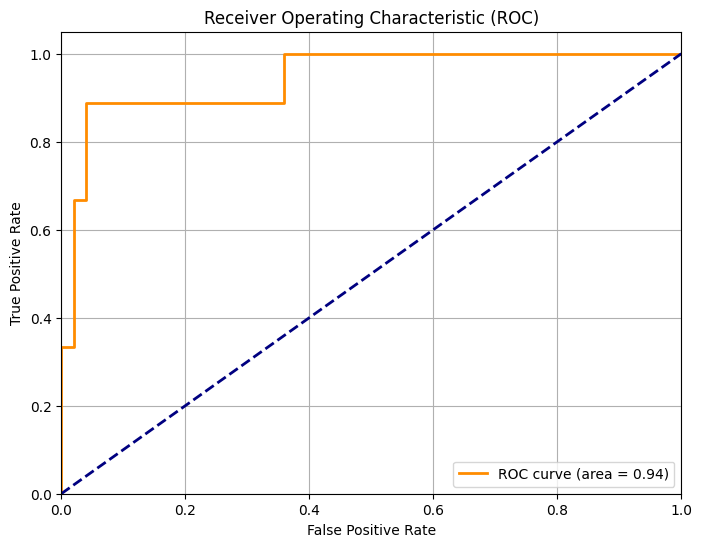

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get probabilities
y_pred_probs = model.predict(X_val).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


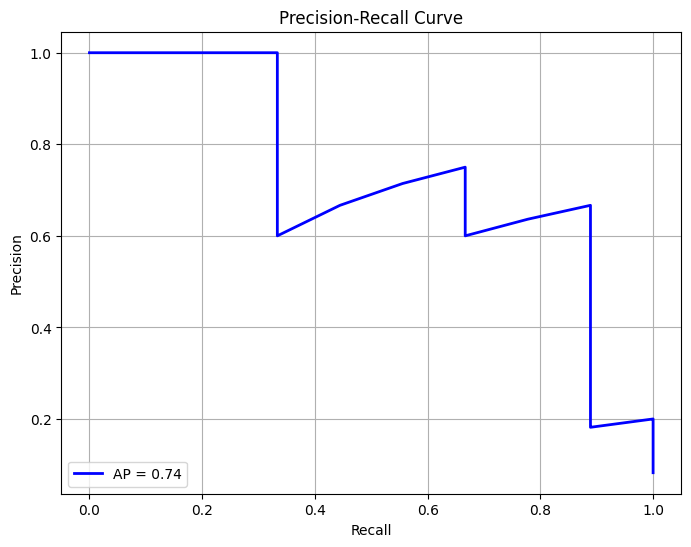

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_probs)
average_precision = average_precision_score(y_val, y_pred_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [ ]:
model.save('voice_model.h5')  # HDF5 format


In [ ]:
from google.colab import files
files.download('voice_model.h5')
